In [17]:
# %%
import os, re, string, joblib
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# spaCy (optional)
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    USE_SPACY = True
except:
    nlp = None
    USE_SPACY = False

RANDOM_STATE = 42


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hazem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hazem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hazem\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:

def load_kaggle_fake_real_news(data_dir="."):
    data_dir = Path(data_dir)
    true_path, fake_path = data_dir/r'C:\Users\hazem\Downloads\archive (5)\True.csv', data_dir/r'C:\Users\hazem\Downloads\archive (5)\Fake.csv'
    
    if true_path.exists() and fake_path.exists():
        df_true, df_fake = pd.read_csv(true_path), pd.read_csv(fake_path)
        df_true["label"], df_fake["label"] = "REAL", "FAKE"
        df = pd.concat([df_true, df_fake])
        df["text"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()
        return df[["text","label"]]
    else:
        raise FileNotFoundError("Place True.csv and Fake.csv in the working directory.")

raw_df = load_kaggle_fake_real_news(".")
print(raw_df.head())
print(raw_df["label"].value_counts())


                                                text label
0  As U.S. budget fight looms, Republicans flip t...  REAL
1  U.S. military to accept transgender recruits o...  REAL
2  Senior U.S. Republican senator: 'Let Mr. Muell...  REAL
3  FBI Russia probe helped by Australian diplomat...  REAL
4  Trump wants Postal Service to charge 'much mor...  REAL
FAKE    23481
REAL    21417
Name: label, dtype: int64


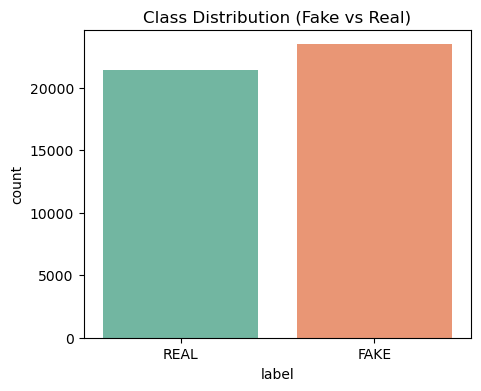

In [19]:
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=raw_df, palette="Set2")
plt.title("Class Distribution (Fake vs Real)")
plt.show()


In [20]:
URL_RE = re.compile(r"https?://\S+|www\.\S+")
HTML_RE = re.compile(r"<.*?>")
PUNC_TABLE = str.maketrans("", "", string.punctuation)
STOPWORDS = set(stopwords.words("english"))
wnl = WordNetLemmatizer()

def clean_text(text):
    x = str(text).lower()
    x = URL_RE.sub(" ", x)
    x = HTML_RE.sub(" ", x)
    x = re.sub(r"\d+", " ", x)
    x = x.translate(PUNC_TABLE)
    x = re.sub(r"\s+", " ", x).strip()
    tokens = [t for t in x.split() if t not in STOPWORDS]
    if USE_SPACY:
        doc = nlp(" ".join(tokens), disable=["ner","parser"])
        tokens = [tok.lemma_ for tok in doc]
    else:
        tokens = [wnl.lemmatize(t) for t in tokens]
    return " ".join(tokens)

raw_df["text_clean"] = raw_df["text"].map(clean_text)
print(raw_df.head())


                                                text label  \
0  As U.S. budget fight looms, Republicans flip t...  REAL   
1  U.S. military to accept transgender recruits o...  REAL   
2  Senior U.S. Republican senator: 'Let Mr. Muell...  REAL   
3  FBI Russia probe helped by Australian diplomat...  REAL   
4  Trump wants Postal Service to charge 'much mor...  REAL   

                                          text_clean  
0  u budget fight loom republican flip fiscal scr...  
1  u military accept transgender recruit monday p...  
2  senior u republican senator let mr mueller job...  
3  fbi russia probe helped australian diplomat ti...  
4  trump want postal service charge much amazon s...  


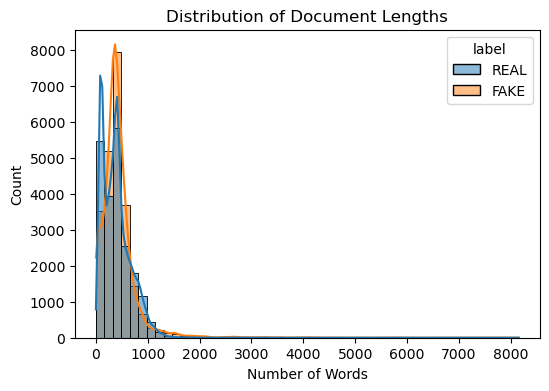

In [21]:
raw_df["doc_length"] = raw_df["text"].str.split().map(len)

plt.figure(figsize=(6,4))
sns.histplot(data=raw_df, x="doc_length", hue="label", bins=50, kde=True)
plt.title("Distribution of Document Lengths")
plt.xlabel("Number of Words")
plt.show()


In [22]:

X = raw_df["text_clean"].values
y = raw_df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(len(X_train), len(X_test))


35918 8980


In [23]:
vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1,2), min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf.shape, X_test_tfidf.shape


((35918, 100000), (8980, 100000))

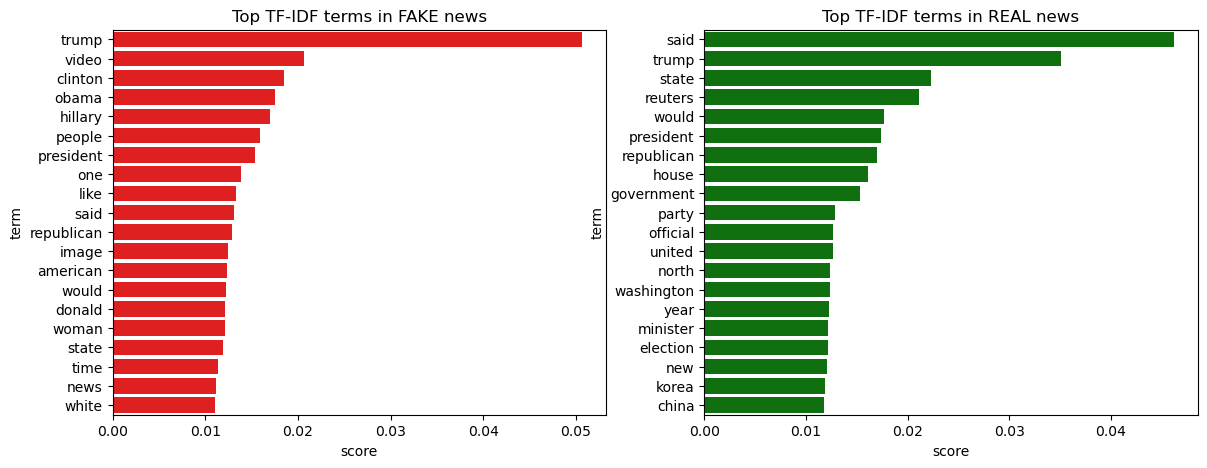

In [24]:
def top_tfidf_features(vectorizer, X, y, label, top_n=20):
    """Extract top TF-IDF terms for a given class label"""
    idx = (y == label)
    X_class = X[idx]
    mean_tfidf = np.asarray(X_class.mean(axis=0)).ravel()
    terms = np.array(vectorizer.get_feature_names_out())
    top_idx = mean_tfidf.argsort()[::-1][:top_n]
    return pd.DataFrame({"term": terms[top_idx], "score": mean_tfidf[top_idx]})

# Compute on training set
top_fake = top_tfidf_features(vectorizer, X_train_tfidf, y_train, "FAKE")
top_real = top_tfidf_features(vectorizer, X_train_tfidf, y_train, "REAL")

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(y="term", x="score", data=top_fake, ax=axes[0], color="red")
axes[0].set_title("Top TF-IDF terms in FAKE news")
sns.barplot(y="term", x="score", data=top_real, ax=axes[1], color="green")
axes[1].set_title("Top TF-IDF terms in REAL news")
plt.show()


In [25]:
lr = LogisticRegression(max_iter=200, solver="liblinear", class_weight="balanced")
lr.fit(X_train_tfidf, y_train)

svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_tfidf, y_train)


c:\Users\hazem\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(class_weight='balanced')


Logistic Regression
Accuracy: 0.9900890868596882
F1: 0.9900905410797958
              precision    recall  f1-score   support

        FAKE       0.99      0.99      0.99      4696
        REAL       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



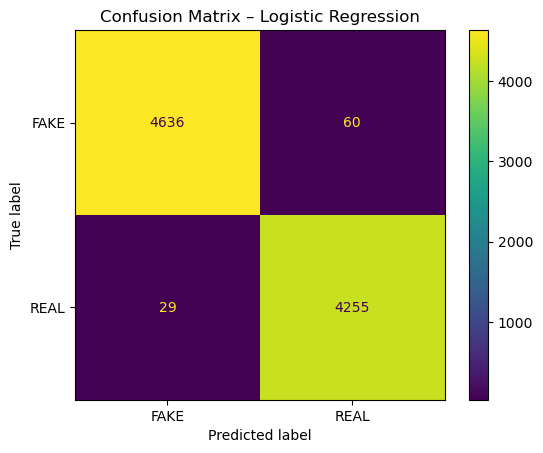


Linear SVM
Accuracy: 0.9964365256124722
F1: 0.9964365619237123
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      4696
        REAL       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



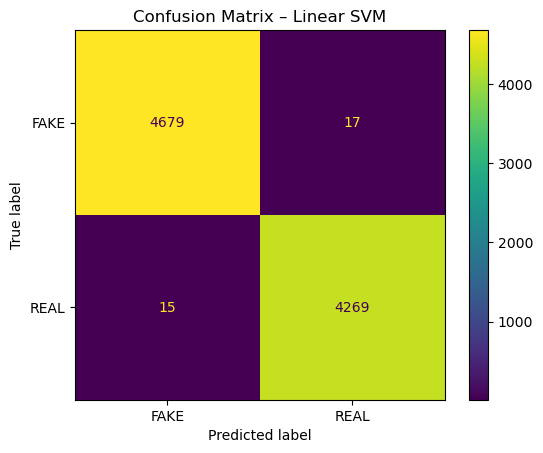

In [26]:

def evaluate(model, name):
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred, average="weighted"))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Confusion Matrix – {name}")
    plt.show()

evaluate(lr, "Logistic Regression")
evaluate(svm, "Linear SVM")


In [27]:
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=150000, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=300, solver="liblinear", class_weight="balanced"))
])
param_grid = {"clf__C": [0.5, 1, 2]}
grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)


{'clf__C': 2} 0.9899507202171711


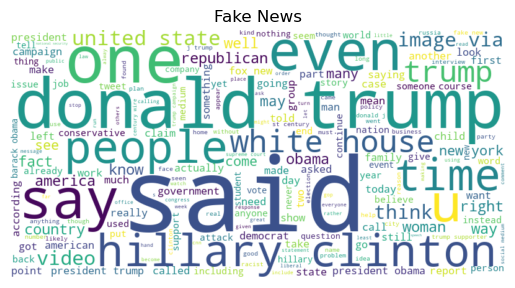

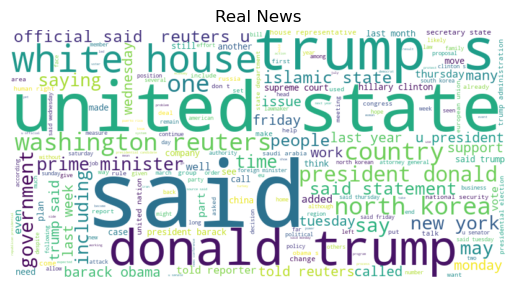

In [28]:
from wordcloud import WordCloud

def plot_wc(texts, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(texts))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wc(raw_df.loc[raw_df.label=="FAKE","text_clean"], "Fake News")
plot_wc(raw_df.loc[raw_df.label=="REAL","text_clean"], "Real News")


In [29]:
joblib.dump(lr, "logreg_model.joblib")
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

loaded_vec = joblib.load("tfidf_vectorizer.joblib")
loaded_model = joblib.load("logreg_model.joblib")

examples = [
    "NASA discovers water on Mars in new images",
    "You won’t believe what this celebrity said about elections!!!"
]
X_new = loaded_vec.transform(examples)
print(loaded_model.predict(X_new))


['FAKE' 'REAL']
